In [52]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, kstest
from scipy import stats

sns.set(style='whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

In [53]:
dalst = pd.read_csv("/kaggle/input/dalstcsv/dalst.csv")
observ_data = pd.read_csv("/kaggle/input/annavg3/annAvg_data2.csv")

In [54]:
dalst =  dalst.drop(columns= ['u(s)','#','tauc','Da'])

In [55]:
threshold = 531.43 #this is the 95th percentile of the taut values. This was computed using the {quantile.(0.95)} method

In [56]:
dalst = dalst.query('taut < @threshold') 

In [57]:
def upper_fence(data):
  # Calculate the first and third quartiles.
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)

  # Calculate the interquartile range.
  iqr = q3 - q1

  # Calculate the upper fence.
  upper_fence = q3 + 1.5 * iqr

  return upper_fence

In [58]:
# creating a new df that consists of just the taut values of the dalst dataset to look at distribution of taut values
dalst_shape_plot = pd.DataFrame(dalst['taut'])
dalst_shape_plot = dalst_shape_plot.sort_values(by='taut', ascending=True)

dalst_shape_plot.reset_index(drop=True, inplace=True)
dalst_shape_plot.iloc[:,0]

0       153.5
1       158.0
2       158.0
3       160.2
4       160.6
        ...  
1529    525.1
1530    528.9
1531    529.2
1532    530.1
1533    531.4
Name: taut, Length: 1534, dtype: float64

In [59]:
dalst_shape_plot.iloc[:,0].describe()

count    1534.000000
mean      271.449739
std        76.715212
min       153.500000
25%       216.525000
50%       249.600000
75%       306.150000
max       531.400000
Name: taut, dtype: float64

In [60]:
#count_true_values = sum(filtered_df['taut'])
#print(count_true_values)

In [61]:
filtered_df = pd.DataFrame([dalst_shape_plot.iloc[:,0] > 531.43]).T

# Count the number of values above the 95th percentile
outlier_count = sum(filtered_df['taut'])

print(f"Number of values greater than the 95th percentile: {outlier_count}")
print(f"Percentage of values greater than the 95th percentile: {outlier_count / dalst_shape_plot.iloc[:,0].shape[0] * 100:.2f}%")

Number of values greater than the 95th percentile: 0
Percentage of values greater than the 95th percentile: 0.00%


In [62]:
frequency_distribution = pd.DataFrame(dalst_shape_plot['taut'].value_counts())

In [63]:
frequency_distribution = frequency_distribution.reset_index(drop= False)

In [64]:
frequency_distribution = frequency_distribution.rename(columns={'index': 'values'})
frequency_distribution = frequency_distribution.rename(columns={'taut': 'frequency'})
frequency_distribution = frequency_distribution.sort_values(by='values').reset_index(drop=True)

In [65]:
frequency_distribution

,values,frequency
0,153.5,1
1,158.0,2
2,160.2,1
3,160.6,1
4,162.4,1
...,...,...
1064,525.1,1
1065,528.9,1
1066,529.2,1
1067,530.1,1


In [66]:
'''# Plot the frequency distribution with adjusted color
plt.bar(frequency_distribution['values'], frequency_distribution['frequency'], width = 20, color='darkblue')  # Change color to dark blue
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of "taut" Column')
#plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if necessary
plt.show()'''

'# Plot the frequency distribution with adjusted color\nplt.bar(frequency_distribution[\'values\'], frequency_distribution[\'frequency\'], width = 20, color=\'darkblue\')  # Change color to dark blue\nplt.xlabel(\'Values\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Frequency Distribution of "taut" Column\')\n#plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if necessary\nplt.show()'

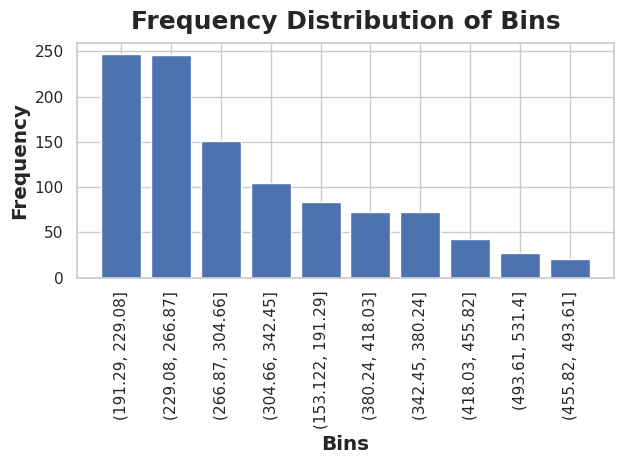

In [67]:
bins = pd.cut(frequency_distribution['values'],bins= 10)

# Count the occurrences of each bin label
bin_counts = bins.value_counts()

# Plot the frequency distribution
plt.bar(bin_counts.index.astype(str), bin_counts.values)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Bins')
plt.xticks(rotation=90)
plt.show()

In [68]:
scaler = MinMaxScaler()
scaler.fit(dalst[['taut']])

# Transform the data
scaled_data = scaler.transform(dalst[['taut']])

# Print the scaled data
print(scaled_data)

[[0.96507012]
 [0.96401164]
 [0.93913734]
 ...
 [0.01190791]
 [0.09896798]
 [0.07621064]]


In [69]:
observ_data = observ_data.dropna()  
observ_data = observ_data.drop(columns = 'salinity')
observ_data

,u,T,q*,tau,hb
9620,9.313333,0.653333,37.658333,0.173354,96.666328
9621,9.369167,0.784167,37.241667,0.174984,97.337638
9632,9.198333,1.121667,28.458333,0.168240,104.087909
9633,9.136667,1.115000,27.933333,0.164165,104.483571
9634,9.132500,1.173333,29.650000,0.160527,104.053442
...,...,...,...,...,...
57595,8.780000,6.525833,-47.458333,0.159559,90.383778
57596,8.790000,6.806667,-56.500000,0.162300,86.810147
57597,8.803333,7.025833,-64.416667,0.166174,87.572182
57598,8.785000,7.178333,-67.816667,0.166310,97.394065


In [70]:
#df_train:1211 (75%)
#df_valid:242 (15%)
#df_test=162 (10%)


In [71]:
def unscale_values(scaled_values, min_value, max_value):
    #return scaled_values * (max_value - min_value) + min_value #this is for [0,1] uncomment when using [-1,-1]
    return ((scaled_values+1)/2) * (max_value - min_value) + min_value
#           unscale_values(, min_['taut'], max_['taut'])

In [72]:
from IPython.display import display

# Create training and validation splits
df_train = dalst.sample(frac=0.75, random_state=0)#this randomly allocates 75% of the data for training
df_valid = dalst.drop(df_train.index)# this makes a copy of the og dataset and removes the training data,leaving the other 25%
df_test  = df_valid.sample(frac=0.40, random_state=0)#explain why .33,(train.75= 1211, valid .15=242, test .1=161)
df_valid = df_valid.drop(df_test.index)#have kyle check this code out to confirm what I did was correct


#display(min_)

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

#df_train = ((df_train - min_) / (max_ - min_))
#df_valid = ((df_valid - min_) / (max_ - min_))
#df_test  = ((df_test  - min_) / (max_ - min_))

df_train = 2*((df_train - min_) / (max_ - min_))-1# this section is for scale -1 to 1
df_valid = 2*((df_valid - min_) / (max_ - min_))-1
df_test  = 2*((df_test  - min_) / (max_ - min_))-1

# scaling observational data 
observ_max = observ_data.max(axis=0)
observ_min = observ_data.min(axis=0)
observ_test= ((observ_data-observ_min) / (observ_max-observ_min))

# Split features and target
X_train = df_train.drop('taut', axis=1)
X_valid = df_valid.drop('taut', axis=1)
y_train = df_train['taut']
y_valid = df_valid['taut']

#format the input to use in the model
X_test  = df_test.drop('taut', axis=1)

In [73]:
df_test

,u,T,q*,tau,hb,taut
930,0.102804,0.335593,0.778082,-0.778426,-1.000000,-0.515265
590,0.102804,-1.000000,0.109589,0.553936,-0.774799,-0.096411
853,0.102804,-0.111864,0.334247,-0.556851,0.109920,0.228709
248,-0.327103,0.335593,0.109589,-1.000000,-0.774799,0.205142
1050,0.327103,-0.783051,0.334247,-0.556851,-0.109920,-0.734333
...,...,...,...,...,...,...
926,0.102804,0.335593,0.334247,-0.778426,-0.554960,-0.498125
453,-0.121495,-0.111864,0.778082,-0.556851,-1.000000,-0.431173
393,-0.121495,-0.559322,0.778082,-0.778426,-0.109920,-0.374933
1001,0.327103,-1.000000,0.109589,0.775510,-0.774799,-0.787359


In [74]:
'''from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

    def create_model():
    model = keras.Sequential([
        layers.Dense(units=512, activation='LeakyReLU', input_shape=[5]),
        layers.Dropout(rate=0.2),
        layers.Dense(units=512, activation='LeakyReLU'),
        layers.Dropout(rate=0.2),
        layers.Dense(units=512, activation='LeakyReLU'),
        layers.Dropout(rate=0.2),
        layers.Dense(units=512, activation='LeakyReLU'),
        layers.Dense(units=1)  # the linear output layer 
    ])
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    return model

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    model = create_model()  # Create a new model for each fold
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=500,
        callbacks=[early_stopping], 
        verbose=0
    )
    scores = model.evaluate(X_test, test_verif, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    fold_no += 1'''

"from sklearn.model_selection import KFold\n\nkfold = KFold(n_splits=5, shuffle=True)\n\n    def create_model():\n    model = keras.Sequential([\n        layers.Dense(units=512, activation='LeakyReLU', input_shape=[5]),\n        layers.Dropout(rate=0.2),\n        layers.Dense(units=512, activation='LeakyReLU'),\n        layers.Dropout(rate=0.2),\n        layers.Dense(units=512, activation='LeakyReLU'),\n        layers.Dropout(rate=0.2),\n        layers.Dense(units=512, activation='LeakyReLU'),\n        layers.Dense(units=1)  # the linear output layer \n    ])\n    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])\n    return model\n\n# K-fold Cross Validation model evaluation\nfold_no = 1\nfor train, test in kfold.split(X_train, y_train):\n    model = create_model()  # Create a new model for each fold\n    history = model.fit(\n        X_train, y_train,\n        batch_size=64,\n        epochs=500,\n        callbacks=[early_stopping], \n        verbose=0\n    )\n    scor

In [75]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.00001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
    #start_from_epoch = 20,
)

In [76]:
model = keras.Sequential([
    layers.Dense(units=256, activation='LeakyReLU',input_shape=[5]),
    layers.Dropout(rate=0.2),#this was 0.2
    
    layers.Dense(units=256, activation='LeakyReLU'),
    #layers.Dropout(rate=0.2),#this was 0.2
    
    layers.Dense(units=256, activation='LeakyReLU'),
    #layers.Dropout(rate=0.2),#this was 0.2
    
    layers.Dense(units=256, activation='LeakyReLU'),
    #layers.Dropout(rate=0.2),
    # the linear output layer
    layers.Dense(units=1)
])

In [77]:
model.compile(
    loss='mae',
    optimizer='adam',
    metrics=['accuracy'])

Minimum validation loss: 0.10448436439037323
Minimum training loss: 0.08573658019304276


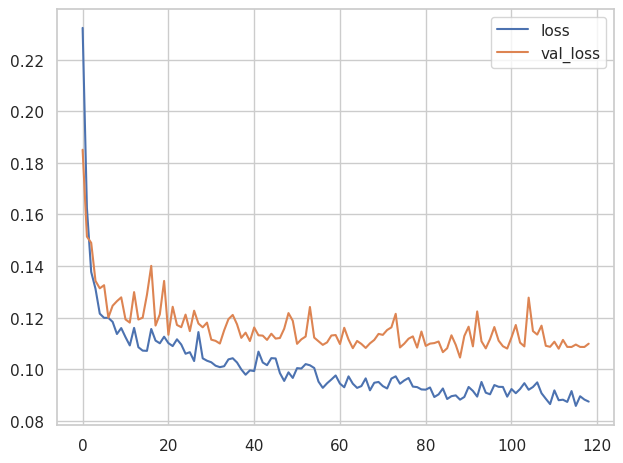

In [78]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=500,
    callbacks=[early_stopping], # put callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)#this creates a new df that keeps track of the training/validation 
history_df.loc[:, ['loss', 'val_loss']].plot();#this is used to visualized the loss history
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
print("Minimum training loss: {}".format(history_df['loss'].min()))

In [79]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.232288,0.00000,0.185044,0.0
1,0.162439,0.00087,0.151371,0.0
2,0.137654,0.00087,0.148952,0.0
3,0.131162,0.00087,0.134202,0.0
4,0.121509,0.00087,0.131329,0.0
...,...,...,...,...
114,0.091485,0.00087,0.108582,0.0
115,0.085737,0.00087,0.109521,0.0
116,0.089481,0.00087,0.108603,0.0
117,0.088191,0.00087,0.108588,0.0


In [80]:
FIRST_PRED = model.predict(X_test)
FIRST_PRED = pd.DataFrame(FIRST_PRED)

5/5 [==============================] - 0s 3ms/step


In [81]:
y_test = df_test['taut'].to_frame()#this a series data type
y_test = y_test.reset_index(drop=True)#this line converts it to a df

In [82]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test.values,FIRST_PRED.values)
mae

0.10544766948588043

In [83]:
mean_absolute_err= print(1-mae)

0.8945523305141195


### Plotting the predicted values vs the actual values

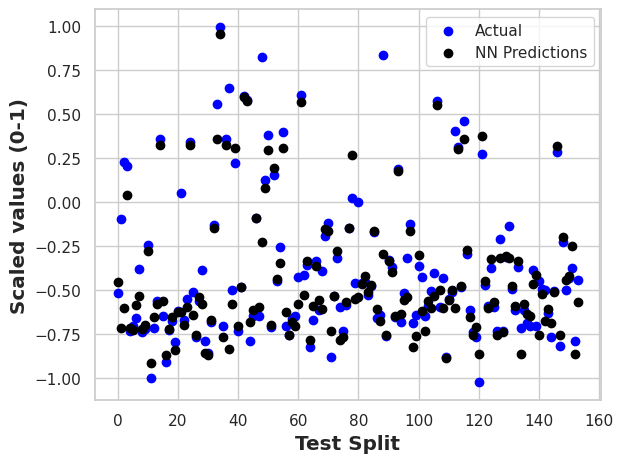

In [84]:
testplot = y_test
modelplot = FIRST_PRED

# Create a scatter plot
plt.scatter(testplot.index,testplot, color='blue', label='Actual')
plt.scatter(modelplot.index, modelplot, color='black', label='NN Predictions')

# Add labels and title
plt.xlabel('Test Split')
plt.ylabel('Scaled values (0-1)')
#plt.title('Actual vs. Predicted Values')

# Add legend
plt.legend()

# Display the plot
plt.show()

In [85]:
from sklearn.metrics import r2_score
r2 = r2_score(testplot, modelplot)
r2

0.6863577258679301

In [86]:
modelplot=modelplot.rename(columns={0: 'predicted'})
testplot =testplot.rename(columns= {'taut': 'actual'})
compare = pd.concat([modelplot, testplot], axis=1)

In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

actual_values = compare['actual']
predicted_values = compare['predicted']

mae = mean_absolute_error(actual_values, predicted_values)#this represents the average absolute difference between actual and predicted values
mse = mean_squared_error(actual_values, predicted_values)#this represents how much the predicted deviates from the from the actual values
r2 = r2_score(actual_values, predicted_values)

In [88]:
predicted_values = compare["predicted"].values
actual_values = compare["actual"].values

# This function calculates the Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual_values, predicted_values)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

MAE: 0.10544766948588043
MSE: 0.055021333441432306
R^2: 0.6863577258679301
Mean Absolute Percentage Error (MAPE): 258.58%


In [89]:
#from tensorflow.keras.models import load_model

# Returns a compiled model identical to the previous one
#temp_model = model('my_model.h5')

In [90]:
''''tautdalst=dalst.columns[:-1]  #this is the dependent variable)

for col in tautdalst:
    sns.lmplot(x=col, y=dalst.columns[-1], data=dalst, ci=None)
    plt.xlabel(col)
    plt.ylabel(dalst.columns[-1])
    plt.title(f'Linear Regression: {col} vs {dalst.columns[-1]}')
    plt.show()'''

"'tautdalst=dalst.columns[:-1]  #this is the dependent variable)\n\nfor col in tautdalst:\n    sns.lmplot(x=col, y=dalst.columns[-1], data=dalst, ci=None)\n    plt.xlabel(col)\n    plt.ylabel(dalst.columns[-1])\n    plt.title(f'Linear Regression: {col} vs {dalst.columns[-1]}')\n    plt.show()"

In [91]:
#the amount of turbulent mixing 
#this model also helps predict along with monitoring areas

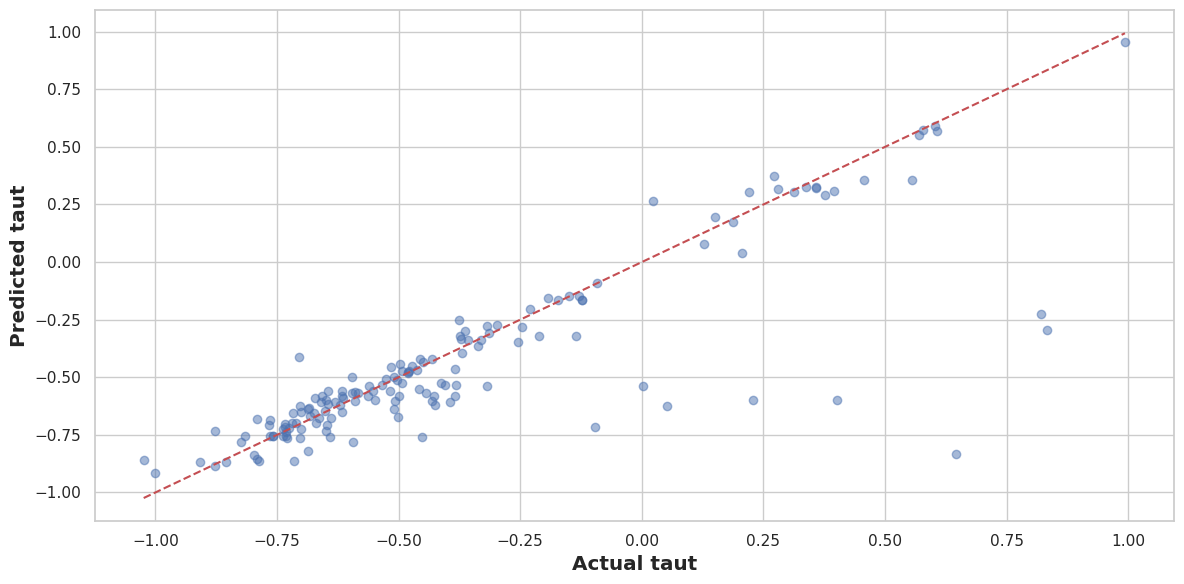

258.58387119779064

In [92]:
# Combining the predictions and actual values into a single DataFrame
results_df = pd.concat([y_test, FIRST_PRED], axis=1)
results_df.columns = ['Actual', 'Predicted']

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')  
plt.xlabel('Actual taut')
plt.ylabel('Predicted taut')
plt.show()

# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((results_df['Actual'] - results_df['Predicted']) / results_df['Actual']))
mape

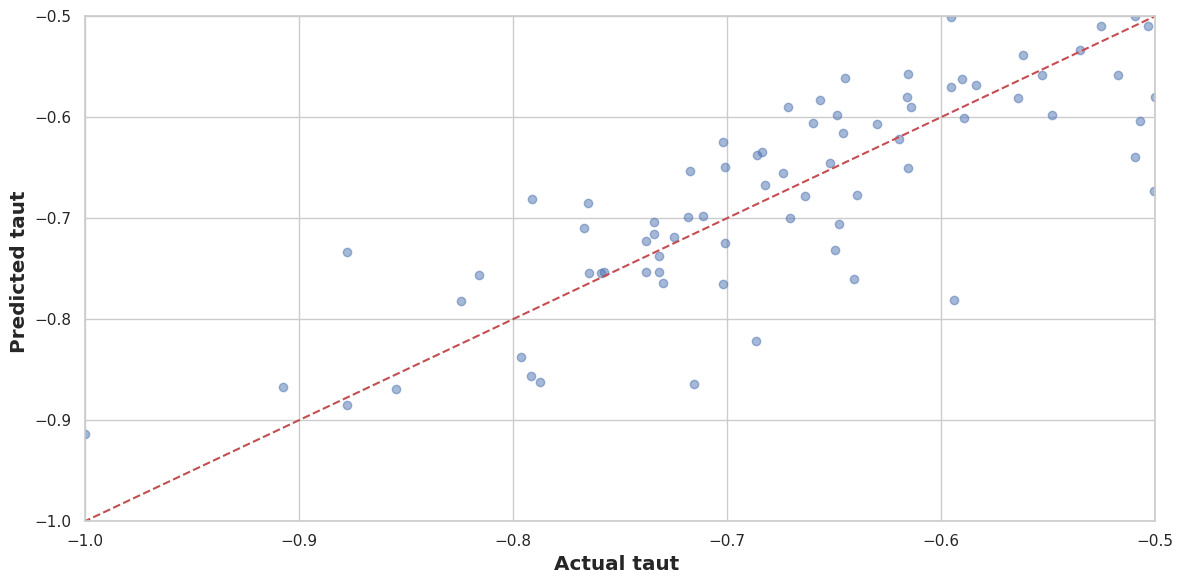

258.58387119779064

In [93]:
# Combining the predictions and actual values into a single DataFrame
results_df = pd.concat([y_test, FIRST_PRED], axis=1)
results_df.columns = ['Actual', 'Predicted']

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)

# Adding the line of perfect prediction
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], 'r--')

# Setting the x-axis to logarithmic scale
#plt.xscale('log')
#plt.yscale('log')

plt.xlim(-1, -0.5)
plt.ylim(-1, -0.5)

# Setting the labels and title
plt.xlabel('Actual taut ')
plt.ylabel('Predicted taut ')
#plt.title('Actual vs. Predicted taut Values')
plt.show()

# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((results_df['Actual'] - results_df['Predicted']) / results_df['Actual']))
mape


In [94]:
# Save the DataFrame to a CSV file
observ_data.to_csv('observ_data.csv', index=False)

In [95]:
'''
# Create a Pandas DataFrame
global_fill_df = pd.DataFrame(global_fill)

# Save the DataFrame to a CSV file
global_fill_df.to_csv('global_fill.csv', index=False)'''

"\n# Create a Pandas DataFrame\nglobal_fill_df = pd.DataFrame(global_fill)\n\n# Save the DataFrame to a CSV file\nglobal_fill_df.to_csv('global_fill.csv', index=False)"

In [96]:
'''results_df['Residuals'] = results_df['Predicted'] - results_df['Actual']

# Set a threshold (e.g., 0.02 or any other value you deem appropriate)
threshold = 0.045

# Filter rows where the absolute residual is greater than the threshold
significant_errors = results_df[abs(results_df['Residuals']) > threshold]
significant_errors'''

"results_df['Residuals'] = results_df['Predicted'] - results_df['Actual']\n\n# Set a threshold (e.g., 0.02 or any other value you deem appropriate)\nthreshold = 0.045\n\n# Filter rows where the absolute residual is greater than the threshold\nsignificant_errors = results_df[abs(results_df['Residuals']) > threshold]\nsignificant_errors"

In [97]:
'''significant_errors_indices = results_df[abs(results_df['Residuals']) > threshold].index

# Assuming `X_test` is your test data
significant_error_rows_dalst = dalst.loc[significant_errors_indices]
significant_error_rows_dalst'''

"significant_errors_indices = results_df[abs(results_df['Residuals']) > threshold].index\n\n# Assuming `X_test` is your test data\nsignificant_error_rows_dalst = dalst.loc[significant_errors_indices]\nsignificant_error_rows_dalst"

In [98]:
'''global_fill=model.predict(observ_test)'''

'global_fill=model.predict(observ_test)'

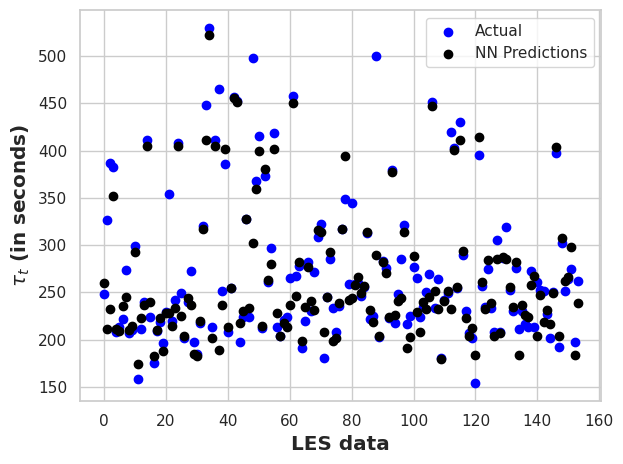

In [99]:
unscale_test = unscale_values(testplot,min_['taut'], max_['taut'])
unscale_model = unscale_values(modelplot,min_['taut'], max_['taut'])

# Create a scatter plot
plt.scatter(unscale_test.index,unscale_test, color='blue', label='Actual')
plt.scatter(unscale_model.index, unscale_model, color='black', label='NN Predictions')

# Add labels and title
plt.xlabel('LES data')
plt.ylabel(r'$\tau_t$'+ " (in seconds)")
#plt.title('Actual vs. Predicted Values')

# Add legend
plt.legend()

# Display the plot
plt.show()


It seems like that for T greater than 400 seconds the performance of the model does not work that well. Perhaps my next step could be looking at the training data and cleaning it so that outliers are removed during training, another thing i can evaluate is the proportion of the training data that is above 400 seconds and see if its

In [100]:
unscale_test.iloc[:,0]
#unscale_model.iloc[:,0]

0      248.5
1      326.7
2      387.4
3      383.0
4      207.6
       ...  
149    251.7
150    264.2
151    274.7
152    197.7
153    261.8
Name: actual, Length: 154, dtype: float64

In [101]:
''''def unscale_values(scaled_values, min_value, max_value):
    scaled_values = np.array(scaled_values)  # Convert to numpy array for element-wise operations
    return 0.5 * (scaled_values + 1) * (max_value - min_value) + min_value

unscale_test = unscale_values(testplot,min_['taut'], max_['taut'])
unscale_model = unscale_values(modelplot,min_['taut'], max_['taut'])

# Create a DataFrame to hold the actual and predicted values
resu = pd.DataFrame({
    'Actual': unscale_test,
    'Predicted': unscale_model
})

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(resu['Actual'], resu['Predicted'], alpha=0.5)
plt.plot([resu['Actual'].min(), resu['Actual'].max()], 
         [resu['Actual'].min(), resu['Actual'].max()], 
         'r--')
plt.xlabel('Actual ' + r'$\tau_t$')
plt.ylabel('Predicted ' + r'$\tau_t$')
plt.show()'''

"'def unscale_values(scaled_values, min_value, max_value):\n    scaled_values = np.array(scaled_values)  # Convert to numpy array for element-wise operations\n    return 0.5 * (scaled_values + 1) * (max_value - min_value) + min_value\n\nunscale_test = unscale_values(testplot,min_['taut'], max_['taut'])\nunscale_model = unscale_values(modelplot,min_['taut'], max_['taut'])\n\n# Create a DataFrame to hold the actual and predicted values\nresu = pd.DataFrame({\n    'Actual': unscale_test,\n    'Predicted': unscale_model\n})\n\n# Plotting the actual vs. predicted values\nplt.figure(figsize=(12, 6))\nplt.scatter(resu['Actual'], resu['Predicted'], alpha=0.5)\nplt.plot([resu['Actual'].min(), resu['Actual'].max()], \n         [resu['Actual'].min(), resu['Actual'].max()], \n         'r--')\nplt.xlabel('Actual ' + r'$\tau_t$')\nplt.ylabel('Predicted ' + r'$\tau_t$')\nplt.show()"

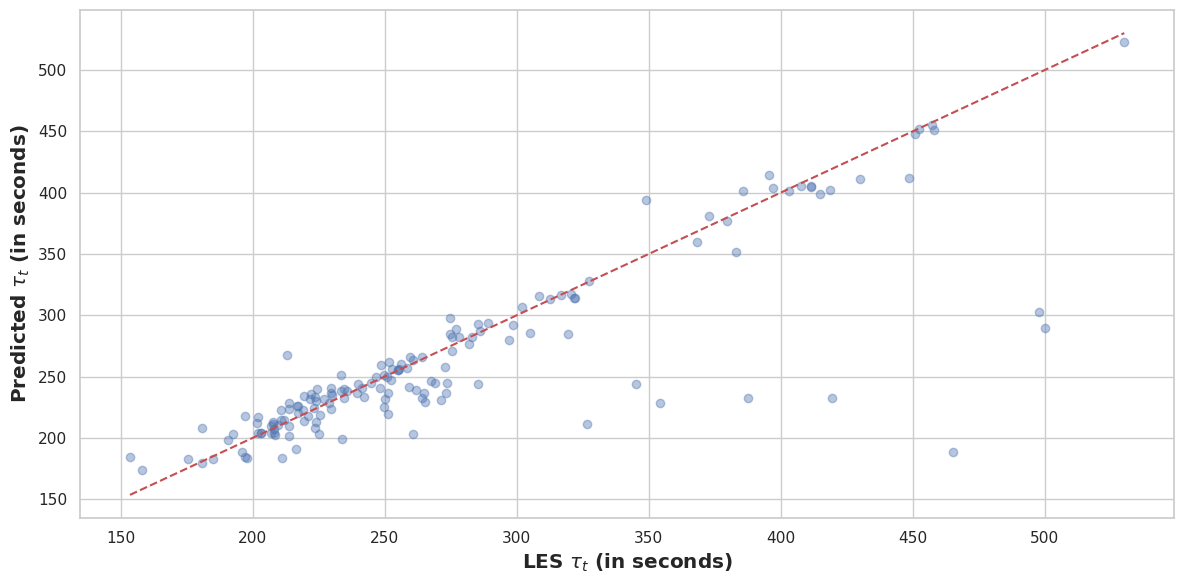

6.37894162835931

In [102]:
unscale_test = unscale_values(testplot, min_['taut'], max_['taut'])

unscale_model = unscale_values(modelplot, min_['taut'], max_['taut'])

# Create a DataFrame to hold the actual and predicted values
resu = pd.DataFrame({
    'Actual': unscale_test.iloc[:,0],
    'Predicted': unscale_model.iloc[:,0]
})

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(resu['Actual'], resu['Predicted'], alpha=0.4)
plt.plot([resu['Actual'].min(), resu['Actual'].max()], 
         [resu['Actual'].min(), resu['Actual'].max()], 
         'r--')
plt.xlabel('LES ' + r'$\tau_t$'+ " (in seconds)")
plt.ylabel('Predicted ' + r'$\tau_t$' + " (in seconds)")

#plt.xscale('log')
#plt.yscale('log')

plt.show()

# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * np.mean(np.abs((resu['Actual'] - resu['Predicted']) / resu['Actual']))
mape